# Conda-Forge Download Statistics

This notebook demonstrates how to load and use Conda-forge
package data.  For more details, see the [Github repository](https://github.com/ContinuumIO/anaconda-package-data/blob/master/README.md).  Due to limitations on Binder, you might find some of the analysis examples below run slowly or require more memory than is available on the Binder instance.  Feel free to download this notebook locally and run it.


## Setting up

To start we need to install the needed packages by running `conda install dask intake numpy pandas` and `conda install -c conda-forge hvplot`. Then we can import the packages:

In [104]:
# !conda install -c conda-forge --yes hvplot intake intake-parquet

In [105]:
import dask.dataframe as dd
from datetime import datetime
import hvplot.pandas
import intake
import numpy as np
import pandas as pd

In [3]:
import distributed

In [4]:
client = distributed.Client()

## Loading Data

There are multiple ways to load Anaconda package data. Below we show examples of loading one month of data for December 2018.

#### Method 1:  load data from S3 url

First, we can read parquet files directly from S3 url. We recommend using `dask.dataframe` to read data files into a Dask DataFrame. Please visit the [Dask website](http://docs.dask.org/en/latest/dataframe.html) for more information.

In [12]:
df = dd.read_parquet(
    's3://anaconda-package-data/conda/hourly/*/*/*.parquet',
    columns=['time', 'data_source', 'counts', 'pkg_name', 'pkg_python'],
    filters=[('data_source', '=', 'conda-forge')],
    storage_options={'anon': True}
)

In [106]:
# Filter out non-conda-forge
df_conda_forge_only = df[df.data_source == 'conda-forge']

In [14]:
df_conda_forge_only

,time,data_source,counts,pkg_name,pkg_python
npartitions=877,,,,,
,datetime64[ns],category[unknown],int64,category[unknown],category[unknown]
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [63]:
df_period_py = df_conda_forge_only.groupby(
    [df_conda_forge_only.time.dt.to_period('D'), df_conda_forge_only.pkg_python]
).counts.sum().compute()

In [64]:
df_period_py.reset_index(level=1).head()

,pkg_python,counts
time,,
2017-03-29,,41032
2017-03-29,2.7,32246
2017-03-29,3.4,2381
2017-03-29,3.5,25041
2017-03-29,3.6,20409


# Overall growth rate of conda-forge by downloads

In [66]:
daily = df_period_py.reset_index(level=1)

In [68]:
quarterly = daily.groupby(daily.index.to_series().dt.asfreq('Q')).counts.sum()

In [96]:
quarterly_yoy_growth = (quarterly - quarterly.shift(4)) / quarterly.shift(4) * 100

In [98]:
pd.DataFrame({"downloads": quarterly, "yoy_growth_perc": quarterly_yoy_growth})

,downloads,yoy_growth_perc
time,,
2017Q1,701645,NaN
2017Q2,23172007,NaN
2017Q3,34139060,NaN
2017Q4,38632180,NaN
2018Q1,56972415,8019.834817
2018Q2,64620212,178.871882
2018Q3,98377527,188.167064
2018Q4,140307194,263.187358
2019Q1,145704942,155.746473


In [72]:
unstacked = df_period_py.unstack()

In [73]:
# Give this a nicer name
unstacked.columns = ["non-python"] + list(unstacked.columns[1:])

In [95]:
unstacked.head()

,non-python,2.6,2.7,3.4,3.5,3.6,3.7,3.8
time,,,,,,,,
2017-03-29,41032.0,NaN,32246.0,2381.0,25041.0,20409.0,NaN,NaN
2017-03-30,103080.0,NaN,72273.0,7785.0,60248.0,52200.0,NaN,NaN
2017-03-31,92143.0,6.0,70491.0,9720.0,60124.0,52466.0,NaN,NaN
2017-04-01,40828.0,NaN,30976.0,2921.0,27220.0,23451.0,NaN,NaN
2017-04-02,43776.0,NaN,30651.0,2568.0,26186.0,22949.0,NaN,NaN


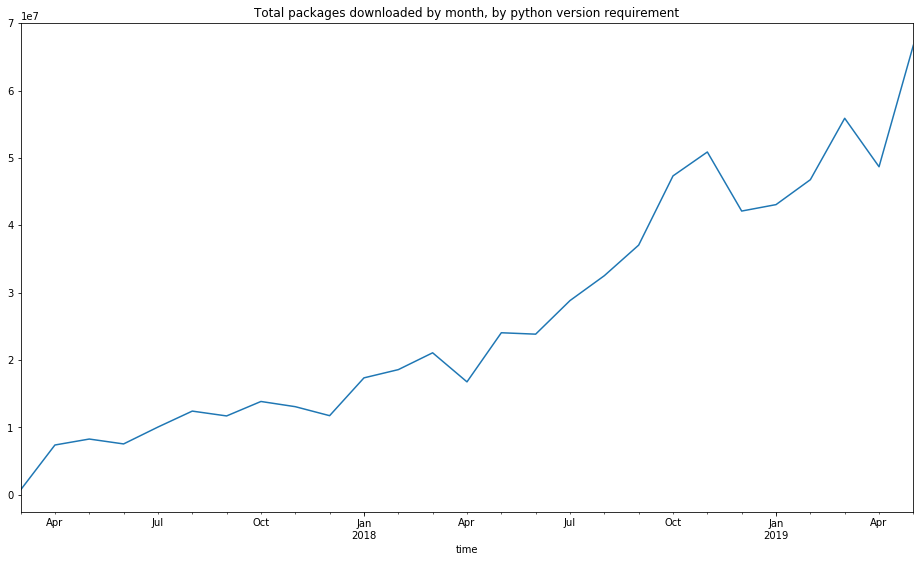

In [103]:
unstacked.asfreq('M').stack().groupby(level=0).sum().plot.line(
    figsize=(16,9),
    title="Total packages downloaded by month, by python version requirement"
)

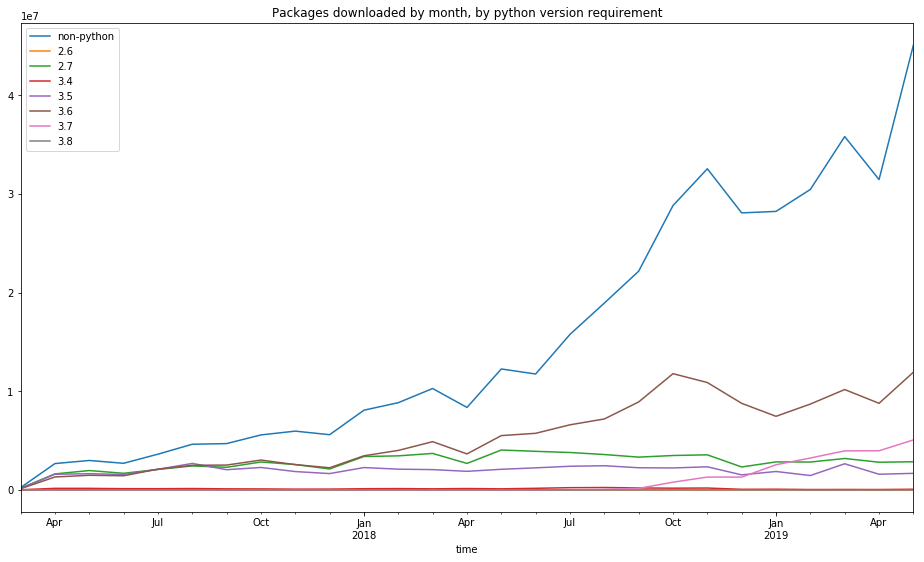

In [94]:
unstacked.groupby(unstacked.asfreq('M').index).sum().plot.line(
    figsize=(16,9),
    title="Packages downloaded by month, by python version requirement"
)

# Most popular packages

In [80]:
total_package_downloads = df_conda_forge_only.groupby(df_conda_forge_only.pkg_name).counts.sum().compute()

In [87]:
pkg_downloads = total_package_downloads[total_package_downloads > 0].sort_values(ascending=False)

In [112]:
pkg_perc = pkg_downloads / pkg_downloads.sum() * 100

In [113]:
pd.DataFrame({'downloads': pkg_downloads, 'percentage': pkg_perc}).head(20)

,downloads,percentage
pkg_name,,
certifi,12626379,1.758450
openssl,11193308,1.558869
ca-certificates,10456441,1.456247
conda,7711862,1.074015
python,7571981,1.054535
setuptools,6797022,0.946608
zlib,6366129,0.886598
pip,6334639,0.882212
sqlite,6165625,0.858674


# Total number of downloads

In [91]:
gdf = df_conda_forge_only.groupby(df_conda_forge_only.time)
out_s = gdf.counts.sum()
total_downloads = out_s.compute()
sum(total_downloads)

718040121